In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
import pathlib

from datetime import datetime, time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from ipywidgets import IntProgress
from IPython.display import display
import time
import statistics


In [2]:
max_count_progress = 100

In [3]:
BASE_DIR = pathlib.Path().cwd()

In [4]:
df = pd.read_csv('base_table.csv', parse_dates= ['call_start_datetime', 'agent_assigned_datetime', 'call_end_datetime'])

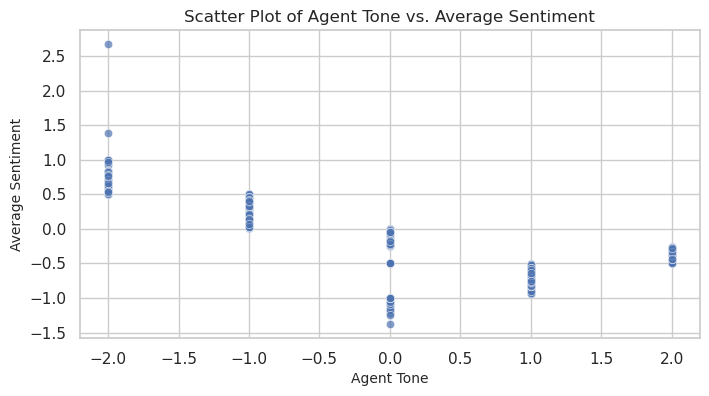

In [5]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 4))
sns.scatterplot(data=df, x='agent_tone', y='average_sentiment', alpha=0.7)

plt.title('Scatter Plot of Agent Tone vs. Average Sentiment', fontsize=12)
plt.xlabel('Agent Tone', fontsize=10)
plt.ylabel('Average Sentiment', fontsize=10)

plt.show()

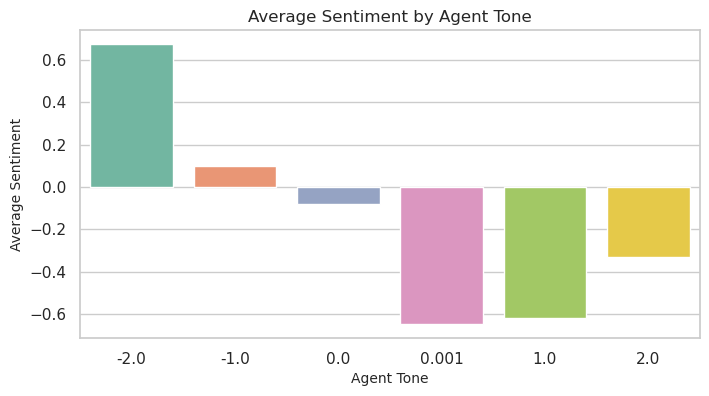

In [6]:
mean_sentiment = df.groupby('agent_tone')['average_sentiment'].mean().reset_index()

plt.figure(figsize=(8, 4))
sns.barplot(data=mean_sentiment, x='agent_tone', y='average_sentiment', hue='agent_tone', palette='Set2', legend=False)

plt.title('Average Sentiment by Agent Tone', fontsize=12)
plt.xlabel('Agent Tone', fontsize=10)
plt.ylabel('Average Sentiment', fontsize=10)

plt.show()

# Inference from agent tone vs average sentiment 
- when agent is getting more frustrated the conversation sentiment seems to go down significantly
- so agents must be properly screened to stay calm during the conversation 

# Correlating Agent Sentiment and Time

## For a single Agent, over a span of days

In [7]:
agent_ramesh = df[df['agent_id'] == 992521]

Text(0.5, 1.0, 'Agent Tone as a function of time')

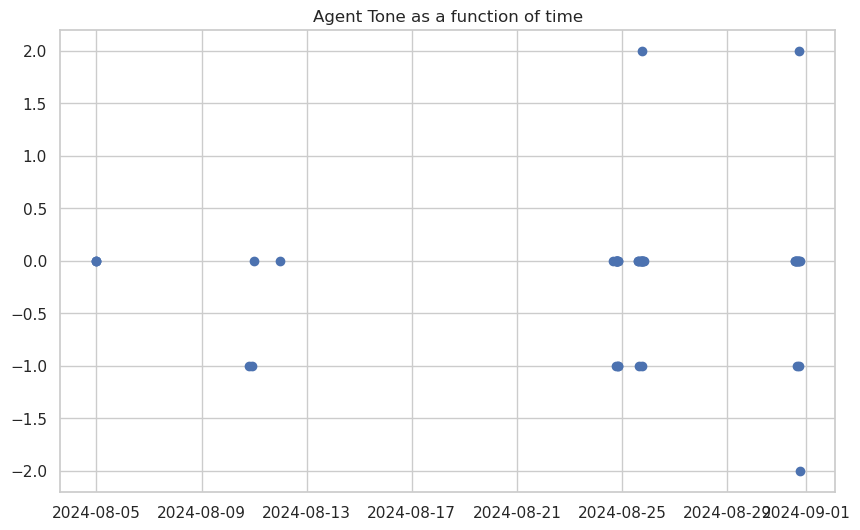

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(agent_ramesh['agent_assigned_datetime'], agent_ramesh['agent_tone'])
plt.title("Agent Tone as a function of time")

<Axes: >

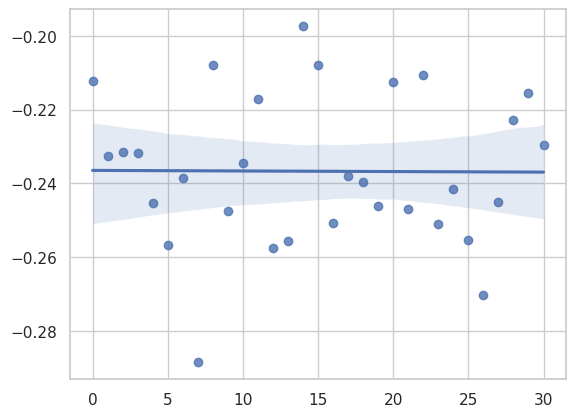

In [9]:
df.sort_values(by='agent_assigned_datetime', ascending=True)
df['agent_assigned_date'] = df['agent_assigned_datetime'].dt.date
average_tone = df.groupby('agent_assigned_date')['agent_tone'].mean()
sns.regplot(x= [x for x in range(len(average_tone))], y= average_tone.values)

In [10]:
statistics.mean(df['agent_tone'])

-0.23801396741400918

In [11]:
len(df[df['agent_tone'] < -0.23 ])

24762

In [12]:
len(df[df['agent_tone'] > -0.23 ])

47048

# Remarks on agent-call distribution
- Here, almost double the number of agents are more frustrated than average tone, also,
- As is evident from the plot, the agent gets more frustrated in the end of the month, which negatively impacts average sentiment
- which, in turn can increase Handle Time (AHT), so this must be fixed

- Another point to be noted is that the calls being received are a lot more sparse than usual, as a result, the idle time of the agent is high

In [41]:
#plt.figure(figsize=(10, 6))
df_forsometime = df[(df['agent_assigned_datetime'] > pd.to_datetime('2024-04-01')) & (df['agent_assigned_datetime'] < pd.to_datetime('2024-10-01'))]
print(len(df_forsometime))

71810


Text(0, 0.5, 'No. of Calls')

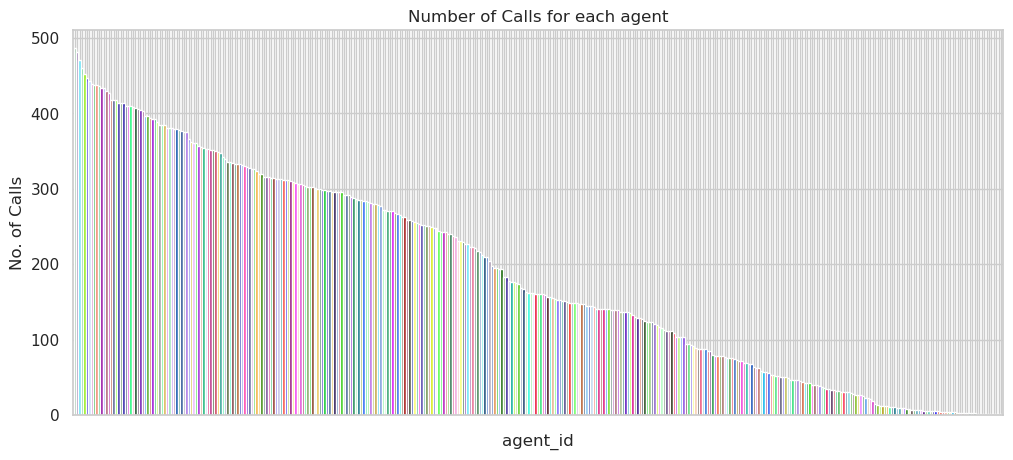

In [65]:
call_counts = df_forsometime['agent_id'].value_counts()

# Generate random colors
np.random.seed(0)  # For reproducibility
colors = np.random.rand(len(df_forsometime), 3)  # Generate random RGB colors

plt.figure(figsize= (12, 5))
pltt = call_counts.plot(kind='bar', color= colors, width= 1)
pltt.set_xticklabels([])
plt.title("Number of Calls for each agent")
plt.ylabel('No. of Calls')

In [14]:
print(statistics.stdev(call_counts))
print(statistics.mean(call_counts))

137.93846543020345
187.4934725848564


## We can clearly see a lot of outliers here
### On the number distribution among the dates
- The standard deviation iof calls received for each agent is very high. So, workload is very high on some, leading to bad AHT in the long run, as the agent tone also goes down over time as the dates pass (see next section)
- So, uniform distribution must be ensured in the queue backend to reduce workload on each, and improve Speed to Answer (AST)

## For a single agent, within a single day

In [15]:
target_date = datetime(2024, 8, 31).date()
test_day_data = df[df['call_start_datetime'].dt.date == target_date]

In [16]:
test_day_data

,Unnamed: 0,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,customer_name,elite_level_code,primary_call_reason,agent_tone,customer_tone,average_sentiment,silence_percent_average,handle_time,speed_to_answer,agent_assigned_date
9,9,811664,3800366680,176703,2024-08-31 09:14:00,2024-08-31 09:25:00,2024-08-31 09:32:00,\n\nAgent: Thank you for calling United Airlin...,James Morales,-1.0,Voluntary Cancel,0.0,1,-0.12,0.37,1080.0,660.0,2024-08-31
15,15,1680609,7567928745,214289,2024-08-31 13:36:00,2024-08-31 13:44:00,2024-08-31 13:57:00,\n\nAgent: Thank you for calling United Airlin...,Natasha Smith,2.0,Mileage Plus,0.0,0,0.00,0.32,1260.0,480.0,2024-08-31
18,18,1829764,6665161812,266966,2024-08-31 01:32:00,2024-08-31 01:40:00,2024-08-31 02:03:00,\n\nAgent: Thank you for calling United Airlin...,Dawn Cooper,-1.0,IRROPS,0.0,1,-0.13,0.28,1860.0,480.0,2024-08-31
29,29,3047948,2118126682,590950,2024-08-31 02:04:00,2024-08-31 02:08:00,2024-08-31 02:17:00,\n\nAgent: Thank you for calling United Airlin...,Wanda Fitzpatrick,-1.0,NaN,0.0,2,-0.10,0.21,780.0,240.0,2024-08-31
55,55,6004660,565991323,132311,2024-08-31 12:30:00,2024-08-31 12:36:00,2024-08-31 12:47:00,\n\nAgent: Thank you for calling United Airlin...,Denise Woods,-1.0,IRROPS,-1.0,-2,0.09,0.19,1020.0,360.0,2024-08-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71741,71741,9990828943,3886942706,769083,2024-08-31 15:18:00,2024-08-31 15:29:00,2024-08-31 16:02:00,\n\nAgent: Thank you for calling United Airlin...,Wendy Whitney,1.0,Voluntary Change,-1.0,1,0.01,0.51,2640.0,660.0,2024-08-31
71750,71750,9991833259,1865564970,302709,2024-08-31 09:06:00,2024-08-31 09:09:00,2024-08-31 09:44:00,\n\nAgent: Thank you for calling United Airlin...,Lisa Fisher,-1.0,Other Topics,0.0,1,-0.03,0.21,2280.0,180.0,2024-08-31
71784,71784,9996977533,4408664107,246791,2024-08-31 03:26:00,2024-08-31 03:33:00,2024-08-31 03:43:00,\n\nAgent: Thank you for calling United Airlin...,Tyler Ford,1.0,Voluntary Change,0.0,1,-0.10,0.49,1020.0,420.0,2024-08-31
71785,71785,9997562479,8843233111,575830,2024-08-31 05:44:00,2024-08-31 05:49:00,2024-08-31 05:53:00,\n\nAgent: Thank you for calling United Airlin...,Morgan Oliver,2.0,IRROPS,0.0,0,-0.24,0.40,540.0,300.0,2024-08-31


# Calm Agents list

In [17]:
unique_sentiments = np.array(['neutral', 'frustrated', 'calm', 'angry', np.nan, 'polite'], dtype=object)
tone_convert = dict(zip(unique_sentiments, [0, 2, -1, 1, 0.001, -2]))
tone_convert_back = {v: k for k, v in tone_convert.items()}
df = df.sort_values(by = 'agent_tone')
calm_agents = df[df['agent_tone'] < 0.001][['agent_id', 'agent_tone']]
calm_agents['agent_tone'] = calm_agents['agent_tone'].apply(lambda x: tone_convert_back[x])
calm_agents

,agent_id,agent_tone
15104,265196,polite
48193,149315,polite
38540,788537,polite
27050,119952,polite
68801,461615,polite
...,...,...
27894,542034,neutral
27895,955854,neutral
27922,202868,neutral
27909,395062,neutral
